# Recommendation Systems with IBM

In this notebook, I will build a number of different methods for making recommendations that can be used for different situations. The data used for this experiment is real data from the IBM Watson Studio platform.


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>

Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

from sklearn.metrics import f1_score, recall_score, precision_score

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

On the cells below I provide some insight into the descriptive statistics of the data.

#### Distribution of how many articles a user interacted with in the dataset.

In [3]:
df.groupby('email')['article_id'].count().head()

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
Name: article_id, dtype: int64

In [4]:
user_article_interactions = df.groupby('email')['article_id'].count()
user_article_interactions.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

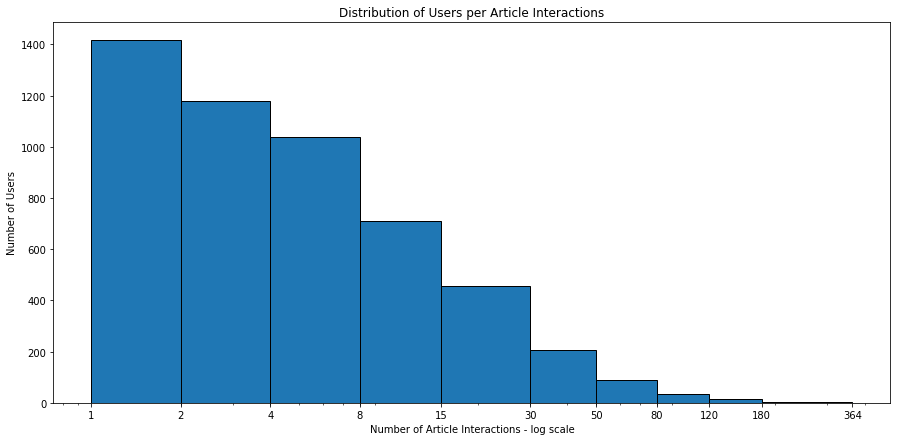

In [5]:
bins = [1,2,4,8,15,30,50,80,120,180,364]
xticks = np.array(bins)
plt.figure(figsize=(15,7))
plt.hist(user_article_interactions, bins=bins, ec='black')
plt.yscale('linear')
plt.xscale('log')
plt.xticks(xticks, xticks.astype(str))
plt.title('Distribution of Users per Article Interactions')
plt.xlabel('Number of Article Interactions - log scale')
plt.ylabel('Number of Users');

In [6]:
# median and maximum number of user_article interactios
median_val = user_article_interactions.median()
max_views_by_user = user_article_interactions.max()

print('50% of individuals interact with {} articles or less.'.format(int(median_val)))
print('The maximum number of user-article interactions by any 1 user is {}.'.format(max_views_by_user))

50% of individuals interact with 3 articles or less.
The maximum number of user-article interactions by any 1 user is 364.


#### Explore and remove duplicate articles from the **df_content** dataframe.

In [7]:
# Find and explore duplicate articles
print('There are a total of {} duplicated articles.'.format(
      df_content[df_content['article_id'].duplicated()]['article_id'].count()))

df_content[df_content['article_id'].duplicated()]

There are a total of 5 duplicated articles.


,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [8]:
# Remove any rows that have the same article_id - only keep the first
print('Number of articles before removing duplicates: {}'.format(df_content.shape[0]))
df_content.drop_duplicates(subset=['article_id'], keep='first', inplace=True)
print('Number of articles after removing duplicates: {}'.format(df_content.shape[0]))

Number of articles before removing duplicates: 1056
Number of articles after removing duplicates: 1051


#### Some more descriptive statistics about the datasets.

In [9]:
unique_articles = df['article_id'].nunique()
total_articles = df_content['article_id'].nunique()
unique_users = df['email'].nunique()
user_article_interactions = df.shape[0]

print('Number of unique articles that have at least one interaction: {}'.format(unique_articles))
print('Number of unique articles on the IBM platform: {}'.format(total_articles))
print('Number of unique users on the IBM platform: {}'.format(unique_users))
print('Number of user-article interactions: {}'.format(user_article_interactions))

Number of unique articles that have at least one interaction: 714
Number of unique articles on the IBM platform: 1051
Number of unique users on the IBM platform: 5148
Number of user-article interactions: 45993


#### The most viewed article and how often it was viewed.

In [10]:
most_viewed_article_id = df['article_id'].value_counts().index[0].astype(str)
max_views = df.groupby('article_id')['email'].count().max()

print('The most viewed article in the dataset is {} and has {} number of interactions.'
      .format(most_viewed_article_id, max_views))

The most viewed article in the dataset is 1429.0 and has 937 number of interactions.


In [11]:
# Map the user email to a user_id column and remove the email column
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We don't have ratings for whether a user liked an article or not, we only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

The function below returns the **n** top articles ordered with most interactions as the top.

In [13]:
n = 10
top_articles_idx = df['article_id'].value_counts().index[:n]
top_articles = list(df[df['article_id'].isin(top_articles_idx)]['title'].unique())
top_articles

['healthcare python streaming application demo',
 'use deep learning for image classification',
 'apache spark lab, part 1: basic concepts',
 'predicting churn with the spss random tree algorithm',
 'analyze energy consumption in buildings',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'gosales transactions for logistic regression model',
 'insights from new york car accident reports',
 'finding optimal locations of new store using decision optimization']

In [14]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles_idx = df['article_id'].value_counts().index[:n]
    top_articles = list(df[df['article_id'].isin(top_articles_idx)]['title'].unique())
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list with the ids top 'n' article titles 
    
    '''
    top_articles = list(df['article_id'].value_counts().index[:n].astype(str))
    
    return top_articles # Return the top article ids

In [15]:
print('The titles of the top 10 articles are:\n{}\n'.format(get_top_articles(10)))
print('The ids of the top 10 articles are:\n{}'.format(get_top_article_ids(10)))

The titles of the top 10 articles are:
['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']

The ids of the top 10 articles are:
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


The function below reformats the **df** dataframe to be shaped with users as the rows, articles as the columns and follows the rules:

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* If a user **has interacted** with an article, then place a **1** where the user-row meets for that article-column.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* If a user **has not interacted** with an item, then we place a **0** where the user-row meets for that article-column. 

In [17]:
# function to create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.drop_duplicates().groupby(['user_id','article_id']).count().unstack()
    user_item = user_item.isnull().applymap(lambda x: 0 if x else 1)
    
    return user_item # return the user_item matrix

user_item = create_user_item_matrix(df)

The function below takes a user_id and provides an ordered list of the most similar users to that user (from most similar to least similar).  The returned result does not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users.

In [19]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    most_similar_users = user_item.loc[user_id].dot(user_item.T)
    
    # sort by similarity
    most_similar_users = most_similar_users.sort_values(ascending=False)
    
    # remove the own user's id
    most_similar_users.drop(user_id, inplace=True)
    
    # create list of just the ids
    most_similar_users = list(most_similar_users.index)
    
    return most_similar_users # return a list of the users in order from most to least similar   

In [20]:
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


Now that we have a function that provides the most similar users to each user, I will want to use these users to find articles I can recommend.

The functions below to return the articles we would recommend to each user.

In [21]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = list(df[df['article_id'].isin(article_ids)]['title'].unique())
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = user_item.columns.values[user_item.loc[user_id] == 1]
    article_ids = [str(article_id[1]) for article_id in article_ids]
    
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    similar_users = find_similar_users(user_id)
    user_article_ids, _ = get_user_articles(user_id)
    rec_ids = []
    
    for similar_user in similar_users:
        if len(rec_ids) < m:
            rec_article_ids, _ = get_user_articles(similar_user)
            possible_recs = np.setdiff1d(rec_article_ids, user_article_ids, assume_unique=True)
            for rec in possible_recs:
                if rec not in rec_ids:
                    rec_ids.append(rec)
        else:
            break
            
    recs = rec_ids[:m]
    
    return recs # return your recommendations for this user_id

In [22]:
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'graph-based machine learning',
 'using brunel in ipython/jupyter notebooks',
 'experience iot with coursera',
 'the 3 kinds of context: machine learning and the art of the frame',
 'deep forest: towards an alternative to deep neural networks',
 'this week in data science (april 18, 2017)',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty']

Now to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when I obtain users who are all the same closeness to a given user - we should choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, I choose the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [24]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # create a Dataframe with the similarity of each user to the provided user
    similarity = pd.DataFrame(user_item.loc[user_id].dot(user_item.T)).drop(user_id).reset_index()
    
    # create a Dataframe with the number of article interactions per user
    num_interactions = df.groupby('user_id')['article_id'].count().drop(user_id).reset_index()
    
    # join the previous Dataframes on user_id
    neighbors_df = similarity.merge(num_interactions, on='user_id')
    
    # rename the columns
    neighbors_df.columns = ['neighbor_id','similarity','num_interactions']
    
    # sort by similarity and then by number of interactions
    neighbors_df = neighbors_df.sort_values(['similarity','num_interactions'], ascending=False)

    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10, n_top_articles=unique_articles):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    n_top_articles - (int) only recommend articles from the top n_top_articles
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    top_article_ids = get_top_article_ids(n_top_articles)
    top_sorted_users = get_top_sorted_users(user_id)
    user_article_ids, _ = get_user_articles(user_id)
    rec_ids = []
    
    for sorted_user_id in top_sorted_users['neighbor_id']:
        if len(rec_ids) < m:
            similar_article_ids, _ = get_user_articles(sorted_user_id)
            possible_recs = np.setdiff1d(similar_article_ids, user_article_ids, assume_unique=True)
            possible_recs = np.intersect1d(top_article_ids, possible_recs)
            rec_ids = np.unique(np.append(rec_ids, possible_recs))
            
        else:
            break  
            
    recs = rec_ids[:m]        
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [25]:
# Test the functions
rec_ids, rec_names = user_user_recs_part2(20, 10, 100)
print('IF WE ONLY RECOMMEND FROM THE TOP 100 MOST VIEWED ARTICLES\n')
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

IF WE ONLY RECOMMEND FROM THE TOP 100 MOST VIEWED ARTICLES

The top 10 recommendations for user 20 are the following article ids:
['109.0' '1160.0' '1162.0' '1163.0' '1166.0' '1170.0' '1172.0' '1176.0'
 '12.0' '125.0']

The top 10 recommendations for user 20 are the following article names:
['apache spark lab, part 1: basic concepts', 'timeseries data analysis of iot events by using jupyter notebook', 'analyze energy consumption in buildings', 'apache spark lab, part 3: machine learning', 'analyze open data sets with spark & pixiedust', 'analyze accident reports on amazon emr spark', 'analyzing data by using the sparkling.data library features', 'tensorflow quick tips', 'build a python app on the streaming analytics service', 'statistics for hackers']


In [26]:
rec_ids, rec_names = user_user_recs_part2(20, 10)
print('IF WE RECOMMEND FROM ALL THE {} ARTICLES\n'.format(unique_articles))
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

IF WE RECOMMEND FROM ALL THE 714 ARTICLES

The top 10 recommendations for user 20 are the following article ids:
['1024.0' '1085.0' '109.0' '1150.0' '1151.0' '1152.0' '1153.0' '1154.0'
 '1157.0' '1160.0']

The top 10 recommendations for user 20 are the following article names:
['airbnb data for analytics: washington d.c. listings', 'analyze accident reports on amazon emr spark', 'tensorflow quick tips', 'airbnb data for analytics: venice listings', 'airbnb data for analytics: venice calendar', 'airbnb data for analytics: venice reviews', 'using deep learning to reconstruct high-resolution audio', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: vienna calendar', 'airbnb data for analytics: chicago listings']


In [27]:
user1_most_sim = get_top_sorted_users(1)['neighbor_id'].iloc[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131)['neighbor_id'].iloc[9] # Find the 10th most similar user to user 131

print('The user that is most similar to user 1 is: {}'.format(user1_most_sim))
print('The 10th most similar user to user 131 is: {}'.format(user131_10th_sim))

The user that is most similar to user 1 is: 3933
The 10th most similar user to user 131 is: 242


**When we get a new user on the platform**, we have a cold start problem on our hands. This means we don't have historical information about the user, preventing us from calculating the chosen similarity metric(the dot product, in our case). From the previously developed functions, we would only be able to use the ```get_top_articles``` to get the top articles accross the platform. When we think back to serendipity, novelty, and diversity as means of a good recommendation system, this option won't be great because all new users will be recommended the same articles, further increasing the total number of visualizations of these. To prevent this from happening to some extent, we might consider refining our knowledge/rank based recommendation system to filter articles based on some extra criteria like: geolocation (global, regional and local), time and date when the user accesses the platform and when the article was posted(we might not want to recommend posts older than a year for relevance purposes), referrers (knowing where the visitor came from), the device (mobile or desktop, IOS or Android), browser. All of these would help us customize our recommendations to each user, given that we have access to the behavioral information of the users, in real-time and without any user input. We could also include some filters that the new user can choose from(that would require user input), like: subject/content of the article, date of posting, length of the article, etc.

In [29]:
new_user_recs = get_top_article_ids(10)

### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, I will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

In [33]:
# Load the user_item matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [34]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In this situation, we can use **Singular Value Decomposition(SVD)** from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.

In [35]:
# Perform SVD on the User-Item Matrix
u, s, vt = np.linalg.svd(user_item_matrix)

print('U shape: {}\nS shape: {}\nVtranpose shape: {}'.format(u.shape, s.shape, vt.shape))

U shape: (5149, 5149)
S shape: (714,)
Vtranpose shape: (714, 714)


In this situation, we are able to perform SVD out-of-the-box, because our user_item_matrix doesn't have missing values.

But how do we choose the number of latent features to use?  Running the below cell, we can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.

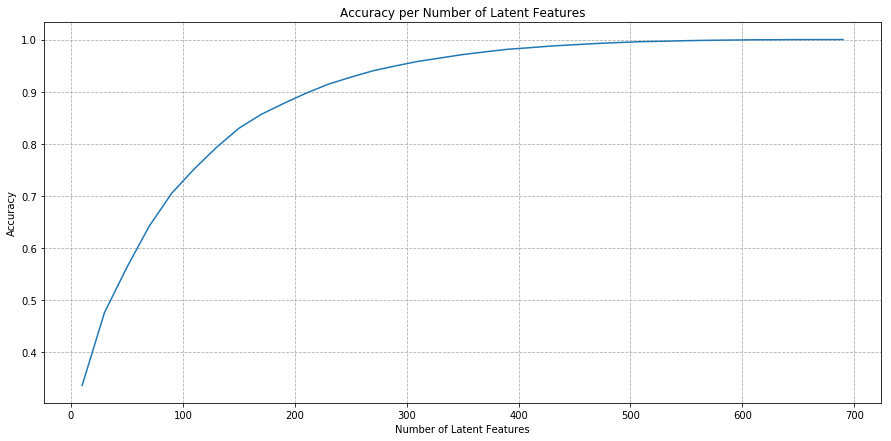

In [36]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
plt.figure(figsize=(15,7))
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0])
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy per Number of Latent Features')
plt.grid(linestyle='--')

From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Next I try to understand the impact on accuracy of the training and test sets of data with different numbers of latent features and to do that I answer the following questions:

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [37]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.get_level_values(1)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [38]:
print('We can make predictions for {} users in the test set.'.format(
    len(np.intersect1d(user_item_train.index, test_idx))))
print('We are not able to make predictions for {} users in the test set because of the cold start problem.'.format(
    len(test_idx) - len(np.intersect1d(user_item_train.index, test_idx))))
print('We can make predictions for {} articles in the test set.'.format(
    len(np.intersect1d(user_item_train.columns.get_level_values(1), test_arts))))
print('We are not able to make predictions for {} articles in the test set because of the cold start problem.'.format(
    len(test_arts) - len(np.intersect1d(user_item_train.columns.get_level_values(1), test_arts))))

We can make predictions for 20 users in the test set.
We are not able to make predictions for 662 users in the test set because of the cold start problem.
We can make predictions for 574 articles in the test set.
We are not able to make predictions for 0 articles in the test set because of the cold start problem.


As we can see above, all of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.

Now I will use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then I will find the subset of rows in the **user_item_test** dataset that I can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. 

In [40]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

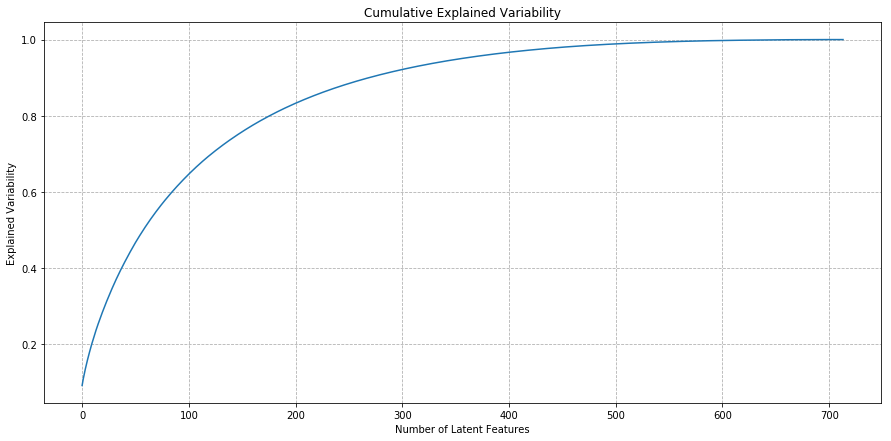

In [41]:
# calculate the total variabillity explained by the latent features
total_variabillity = np.sum((s_train)**2)

acum_variabillity = dict()
i_variabillity = dict()
acum = 0

for i,k in enumerate(s_train):
    # calculate the variabillity explained per latent feature
    i_variabillity[i] = k / total_variabillity
    acum += k ** 2
    # calculate the cumulative explained variabillity
    acum_variabillity[i] = acum / total_variabillity
    
df_acum_variabillity = pd.DataFrame.from_dict(acum_variabillity, orient='index')  

df_acum_variabillity.plot.line(figsize=(15,7), legend=False)
plt.title("Cumulative Explained Variability")
plt.xlabel("Number of Latent Features")
plt.ylabel("Explained Variability")
plt.grid(linestyle='--')

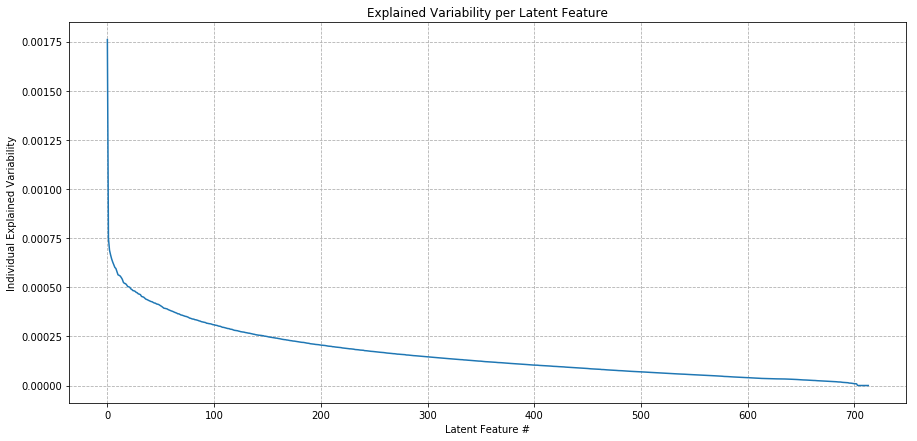

In [42]:
df_i_variabillity = pd.DataFrame.from_dict(i_variabillity, orient='index') 

df_i_variabillity.plot.line(figsize=(15,7), legend=False)
plt.title("Explained Variability per Latent Feature")
plt.xlabel("Latent Feature #")
plt.ylabel("Individual Explained Variability")
plt.grid(linestyle='--')

In [43]:
# train user ids and article ids
train_idx = np.array(user_item_train.index.values)
train_arts = np.array(user_item_train.columns.get_level_values(1))

# user ids and article ids present in both training and test sets
test_idx_subset = np.intersect1d(train_idx, test_idx)
test_arts_subset = np.intersect1d(train_arts, test_arts)

# positions of the test subset in the training set
train_idx_subset = np.where(np.in1d(train_idx, test_idx_subset))[0]
train_arts_subset = np.where(np.in1d(train_arts, test_arts_subset))[0]

# position of the test subset in the test matrix
test_idx_subset = np.where(np.in1d(test_idx, test_idx_subset))[0]

# user_item matrix with user ids and article ids present in both training and test sets
user_item_test_subset = user_item_test.iloc[test_idx_subset,:]

In [44]:
n_latent_features = np.arange(1,714,1)
train_errors = []
test_errors = []
test_f1 = []
test_recall = []
test_precision = []

for k in n_latent_features:
    # restructure with k latent features
    u_train_k, s_train_k, vt_train_k = u_train[:, :k], np.diag(s_train[:k]), vt_train[:k, :]
    u_test_k, s_test_k, vt_test_k = u_train_k[train_idx_subset,:k], s_train_k, vt_train_k[:k, train_arts_subset]
    
    # take dot product
    user_item_train_subset_pred = np.around(np.dot(np.dot(u_train_k, s_train_k), vt_train_k))
    user_item_test_subset_pred = np.around(np.dot(np.dot(u_test_k, s_test_k), vt_test_k))
    
    # compute error for each prediction to actual value
    train_diffs = np.subtract(user_item_train, user_item_train_subset_pred)
    test_diffs = np.subtract(user_item_test_subset, user_item_test_subset_pred)
    
    # calculate errors and keep track of them
    train_err = np.sum(np.sum(np.abs(train_diffs)))
    test_err = np.sum(np.sum(np.abs(test_diffs)))
    train_errors.append(train_err)
    test_errors.append(test_err)
    
    # compute f1, recall and precision test scores
    test_f1.append(f1_score(np.array(user_item_test_subset).flatten(),
                            user_item_test_subset_pred.flatten(), labels=[1.0], average='macro'))
    test_recall.append(recall_score(np.array(user_item_test_subset).flatten(),
                                    user_item_test_subset_pred.flatten(), labels=[1.0], average='macro'))
    test_precision.append(precision_score(np.array(user_item_test_subset).flatten(),
                                          user_item_test_subset_pred.flatten(), labels=[1.0], average='macro'))

train_n_interactions_subset = user_item_train.shape[0] * user_item_train.shape[1]
test_n_interactions_subset = user_item_test_subset.shape[0] * user_item_test_subset.shape[1]

# calculate train and test accuracies
train_accuracy = 1 - np.array(train_errors) / train_n_interactions_subset
test_accuracy = 1 - np.array(test_errors) / test_n_interactions_subset

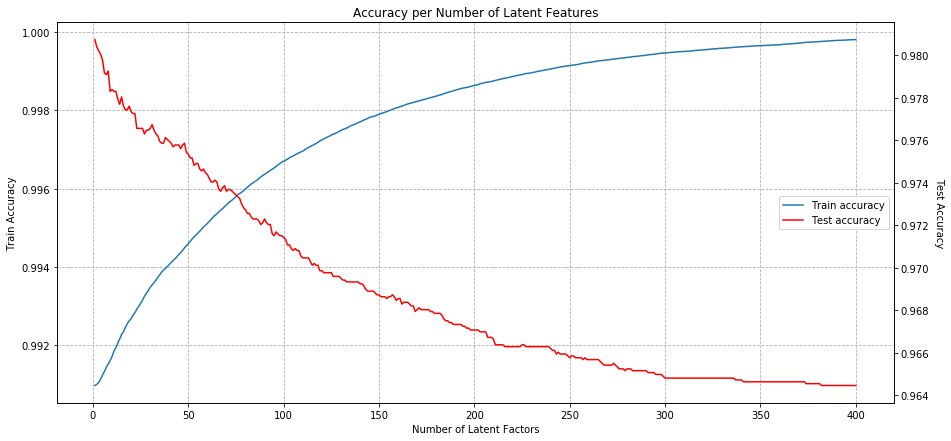

In [45]:
# plot train and test accuracies per number of latent features
fig, ax1 = plt.subplots(figsize=(15,7))
ax2 = ax1.twinx()
# sliced the first 400 instances for readability reasons, 
# because the last instances only overfit the model
ax1.plot(n_latent_features[:400], train_accuracy[:400], label="Train accuracy")
ax2.plot(n_latent_features[:400], test_accuracy[:400], c='red', label="Test accuracy")
legend1, label1 = ax1.get_legend_handles_labels()
legend2, label2 = ax2.get_legend_handles_labels()
ax1.legend(legend1+legend2, label1+label2, loc='right')
ax1.set_title('Accuracy per Number of Latent Features')
ax1.set_xlabel('Number of Latent Factors')
ax1.set_ylabel('Train Accuracy')
ax2.set_ylabel('Test Accuracy', rotation=270, labelpad=15)
ax1.grid(linestyle='--');

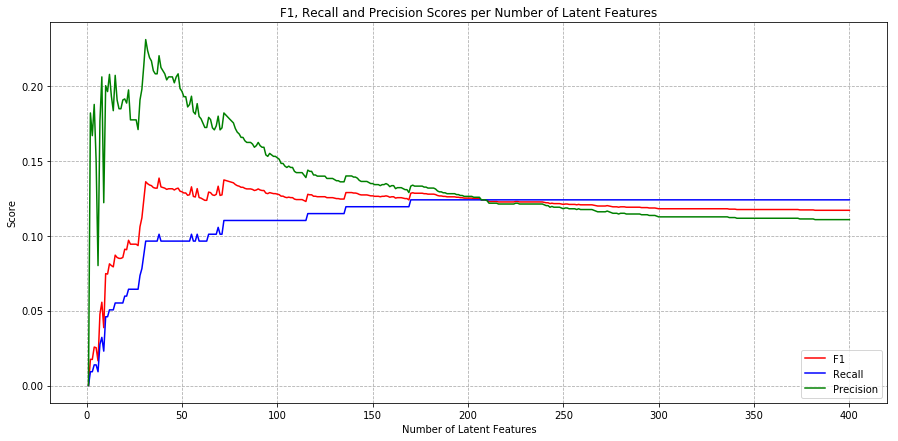

In [46]:
# plot the F1, Recall and Precision Scores per number of latent features
plt.figure(figsize=(15,7))
# sliced the first 400 instances for readability reasons, 
# since the last instances only keep overfitting the model
plt.plot(n_latent_features[:400], test_f1[:400], c='red', label='F1')
plt.plot(n_latent_features[:400], test_recall[:400], c='blue', label='Recall')
plt.plot(n_latent_features[:400], test_precision[:400], c='green', label='Precision')
plt.legend(loc='lower right')
plt.xlabel('Number of Latent Features')
plt.ylabel('Score')
plt.title('F1, Recall and Precision Scores per Number of Latent Features')
plt.grid(linestyle='--');

In [47]:
# print a summary of the obtained score values
print('We achieve a maximum Accuracy score of {:.3f} when we use {} latent features.'.format(
    max(test_accuracy), np.where(np.in1d(test_accuracy, max(test_accuracy)))[0][0]+1))
print('We achieve a maximum F1 score of {:.3f} when we use {} latent features.'.format(
    max(test_f1), np.where(np.in1d(test_f1, max(test_f1)))[0][0]+1))
print('We achieve a maximum Recall score of {:.3f} when we use {} latent features.'.format(
    max(test_recall), np.where(np.in1d(test_recall, max(test_recall)))[0][0]+1))
print('We achieve a maximum Precision score of {:.3f} when we use {} latent features.'.format(
    max(test_precision), np.where(np.in1d(test_precision, max(test_precision)))[0][0]+1))

We achieve a maximum Accuracy score of 0.981 when we use 1 latent features.
We achieve a maximum F1 score of 0.138 when we use 38 latent features.
We achieve a maximum Recall score of 0.124 when we use 170 latent features.
We achieve a maximum Precision score of 0.231 when we use 31 latent features.


As we can see above, as we increase the number of latent features, the training accuracy increases and the test accuracy decreases, usually meaning that we are overfitting the model to the training data. The low number of positive labels(1's) vs high number of negative labels(0's) means that we have an imbalanced dataset on our hands which explains the very high accuracy values. This means that accuracy isn't the best metric to judge our model, hence why I calculated the values for F1, recall and precision. Even though these can give us a better overall insight about the number of latent features we should use(for example, a good starting value would be 38, maximizing the F1 score), the number of test values that we can make predictions for(20) is very low, meaning that these values shouldn't be trusted without further scrutiny.

Alternatively to the offline validation method used previously we could use of an online method to determine the impact of the different recommendation systems. For example, we could do an A/B test to measure the difference in engagement with recommended articles between users in the control group and users in the experimental group. We could use our knowledge/rank based recommendation system as a baseline, against the model based collaborative filtering system that we develop using SVD.